In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [5]:
N_ENSEMBLE=50
drawmedian=False
drawstep=True

In [6]:
def get_mse(chunk_means, djangoh_vals):
    bias = []
    for i in chunk_means:
        bias.append(np.square(np.subtract(i, djangoh_vals)))

    bias_squared = np.mean(bias,axis=0)
    mse = bias_squared/np.mean(djangoh_vals)
    return mse

def get_sigma(y_vals):
    sigma = np.std(y_vals, axis=0)/np.mean(y_vals, axis=0)
    return sigma

In [7]:
def get_stdv_from_files(files, truth=None):

    data = [np.load(file) for file in files]
    
    # Initialize a dictionary to hold lists of y-values for each x-value index
    y_values_per_x_index = {}
    ratio_values_per_x_index = {}
    x_values = np.load(files[0])[0]  # Load the x-values from the first file


    for single_file_data in data:
        for i, y in enumerate(single_file_data[1]):  # single_file_data[1] are the y-values
            if i not in y_values_per_x_index:
                y_values_per_x_index[i] = []
            y_values_per_x_index[i].append(y)        
    
        for i, r in enumerate(single_file_data[2]):  # single_file_data[1] are the y-values
            if i not in ratio_values_per_x_index:
                ratio_values_per_x_index[i] = []
            ratio_values_per_x_index[i].append(r)
    # print(len(y_values_per_x_index))        
    # print(f"y_values_per_x_index: {y_values_per_x_index}")

    mean = [np.mean(y_values) for y_values in y_values_per_x_index.values()]
    # print(f"mean: {mean}")
    if truth is None: #Standard Deviation, using Means
        for y_values in y_values_per_x_index.values():
            # print(y_values)
            std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
        # print(std_devs)
            ratio_std_devs = [np.std(y_values) for y_values in ratio_values_per_x_index.values()]
        

    else: #MSE, from truth. Usually Djanhog in the closure studies
        std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
        ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]
        
    return x_values, std_devs, ratio_std_devs, mean

In [8]:
# def truncated_mean_axis0(data, percentage=10):
#     """
#     Calculate truncated mean along axis 0
    
#     Parameters:
#     -----------
#     data : 2D numpy array
#         Input data array with shape (n_samples, n_features)
#     percentage : float
#         Percentage to trim from both ends (default: 10%)
        
#     Returns:
#     --------
#     1D numpy array
#         Truncated mean for each feature
#     """
#     n_samples = data.shape[0]
#     n_features = data.shape[1]
    
#     # Calculate number of elements to remove from each end
#     k = int(n_samples * percentage / 100 / 2)
    
#     # Initialize result array
#     result = np.zeros(n_features)
    
#     # For each feature (column), calculate truncated mean
#     for i in range(n_features):
#         column = np.sort(data[:, i])
#         # Remove k smallest and k largest values and compute mean
#         result[i] = np.mean(column[k:n_samples-k])
    
#     return result


def truncated_mean_axis0(data):
    """
    Calculate truncated mean along axis 0, removing only the minimum and maximum values
    
    Parameters:
    -----------
    data : 2D numpy array
        Input data array with shape (n_samples, n_features)
        
    Returns:
    --------
    1D numpy array
        Truncated mean for each feature with min and max removed
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    # Initialize result array
    result = np.zeros(n_features)
    
    # For each feature (column), calculate truncated mean
    for i in range(n_features):
        column = np.sort(data[:, i])
        # Remove only the smallest and largest values and compute mean
        result[i] = np.mean(column[1:n_samples-1])
    
    return result

In [29]:
def plot_feature(feature, xlabel, title, unit, drawmedian, drawstep, avg_Npts=0):
    ## first get baseline rapgap and djangoh
    fig = plt.figure(figsize=(20, 5))  # Increased height to accommodate new plots
    outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.2) # 1 row, 3 cols, with padding

    alpha = 0.8
    label_size = 18
    E_Max = 5

    # Load baseline data
    rapgap = np.load(f'../plots/Rapgap_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')
    djangoh = np.load(f'../plots/Djangoh_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')

    # Apply bin averaging if requested
    if avg_Npts > 0:
        # Apply bin averaging to rapgap and djangoh data
        rapgap_x = rapgap[0][:rapgap.shape[1] // avg_Npts * avg_Npts].reshape(-1, avg_Npts)
        rapgap_y = rapgap[1][:rapgap.shape[1] // avg_Npts * avg_Npts].reshape(-1, avg_Npts)
        djangoh_x = djangoh[0][:djangoh.shape[1] // avg_Npts * avg_Npts].reshape(-1, avg_Npts)
        djangoh_y = djangoh[1][:djangoh.shape[1] // avg_Npts * avg_Npts].reshape(-1, avg_Npts)
        
        # Average the bins
        plot_rapgap_x = np.mean(rapgap_x, axis=1)
        plot_rapgap_y = np.mean(rapgap_y, axis=1)
        plot_djangoh_x = np.mean(djangoh_x, axis=1)
        plot_djangoh_y = np.mean(djangoh_y, axis=1)
        
        # Create new arrays with averaged data
        plot_rapgap = np.array([plot_rapgap_x, plot_rapgap_y])
        plot_djangoh = np.array([plot_djangoh_x, plot_djangoh_y])
    else:
        # Use original data without bin averaging
        plot_rapgap = rapgap
        plot_djangoh = djangoh

    # Set up the grid for the ratio plot
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[0], height_ratios=[3, 1], hspace=0.05
    )
    ax1_top = fig.add_subplot(inner_gs[0])
    ax1_bottom = fig.add_subplot(inner_gs[1], sharex=ax1_top)
    
    # Plot the baseline data
    r_scatter = ax1_top.scatter(
        plot_rapgap[0], plot_rapgap[1],
        # marker='_', label='Rapgap',
        marker='_', label='Simulation',
        alpha=alpha, s=100, color='k'
    )
    d_scatter = ax1_top.fill_between(
        plot_djangoh[0], plot_djangoh[1],
        step='mid', color='gray',
        # alpha=0.3, label='Djangoh'
        alpha=0.3, label='Pseudodata'
    )

    # ax1_top.set_title(f'{title}', fontsize=20)
    ax1_top.set_ylabel('Normalized Counts', fontsize=label_size)
    ax1_top.tick_params(axis='both', which='major', labelsize=12)
    # Remove x-axis tick marks and labels on the top subplot
    ax1_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax1_top.grid(True)

    # --- Bottom Subplot: Ratio Plot ---
    ax1_bottom.set_ylabel(r'Ratio', fontsize=label_size)
    ax1_bottom.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax1_bottom.set_ylim(0.5, 1.5)
    ax1_bottom.tick_params(axis='both', which='major', labelsize=12)
    ax1_bottom.grid(True)

    # Group the ensemble models into chunks of 5
    chunk_size = 5
    num_chunks = (N_ENSEMBLE + chunk_size - 1) // chunk_size  # Ceiling division to handle non-divisible cases
    
    # Initialize arrays to store the chunk statistics
    chunk_means = []
    chunk_medians = []
    chunk_truncmeans = []
    chunk_file_paths = []  # Store file paths for each chunk for std_dev calculations
    
    # For storing x values
    x_values = None
    
    ensemble0_yvals = []
    # Process each chunk
    for chunk_idx in range(num_chunks):
        # print(f"pass #: {chunk_idx}")
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, N_ENSEMBLE)
        
        # Arrays to collect data and file paths for this chunk
        chunk_y_vals = []
        chunk_files = []
        
        # Process each ensemble in this chunk
        for n in range(start_idx, end_idx):
            # print(f"ensemble #: {n}")
            step_file = f'../plots/Rapgap_unfolded{n}_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens{n}_plot_vals.npy'
            # print(f"file: {step_file}")
            if not os.path.exists(step_file):
                print(f"Skipping missing file: {step_file}")
                continue
                
            # Add file path to the chunk files
            chunk_files.append(step_file)
            
            step_data = np.load(step_file)
            
            # Apply bin averaging to each ensemble's data if requested
            if avg_Npts > 0 and len(step_data[0]) >= avg_Npts:
                # Truncate data to be divisible by avg_Npts
                trunc_len = len(step_data[0]) // avg_Npts * avg_Npts
                x_data = step_data[0][:trunc_len].reshape(-1, avg_Npts)
                y_data = step_data[1][:trunc_len].reshape(-1, avg_Npts)
                
                # Average the bins
                avg_x = np.mean(x_data, axis=1)
                avg_y = np.mean(y_data, axis=1)
                
                # Store x values once, assuming they're the same for all files after averaging
                if x_values is None:
                    x_values = avg_x
                    
                chunk_y_vals.append(avg_y)
                if (n == 0 or n % 5 == 0): ensemble0_yvals.append(avg_y)
            else:
                # Store x values once, assuming they're the same for all files
                if x_values is None:
                    x_values = step_data[0]
                    
                chunk_y_vals.append(step_data[1])
                if (n == 0 or n % 5 == 0): ensemble0_yvals.append(step_data[1])
                # print(f"step_data[1]: {step_data[1]}")

        
        # Skip empty chunks
        if not chunk_y_vals or len(chunk_files) < 2:  # Need at least 2 files for std dev calculation
            print(f"Skipping empty or single-file chunk {chunk_idx+1}")
            continue
            
        # Convert to numpy array for calculations
        chunk_y_vals_arr = np.vstack(chunk_y_vals)
        
        # Calculate statistics for this chunk
        chunk_mean = np.mean(chunk_y_vals_arr, axis=0)
        chunk_median = np.median(chunk_y_vals_arr, axis=0)
        chunk_truncmean = truncated_mean_axis0(chunk_y_vals_arr)

        # chunk_truncmean = truncated_mean_axis0(chunk_y_vals_arr, percentage=10)
        
        # Store chunk statistics
        chunk_means.append(chunk_mean)
        chunk_medians.append(chunk_median)
        chunk_truncmeans.append(chunk_truncmean)
        chunk_file_paths.append(chunk_files)  # Store file paths for std_dev calculations

    # print(f"ensemble0_yvals: {ensemble0_yvals}")    
    # print(f"len ensemble0_yvals: {len(ensemble0_yvals)}")    

    ensemble0_stdv = np.std(ensemble0_yvals, axis=0)
    ensemble0_mean = np.mean(ensemble0_yvals, axis=0)


    chunk_std_devs = []
    chunk_ratio_std_devs = []  # To store ratio std devs
    chunk_std_dev_ratios = []  # To store ratios between std devs
    
    # Arrays to store per-x-value statistics for the final plots
    all_x_values = None
    all_std_devs_per_x = []
    all_mse_per_x = []
    
    # Arrays to store std_devs for each statistical method
    all_mean_std_devs_per_x = []
    all_median_std_devs_per_x = []
    all_truncmean_std_devs_per_x = []
    
    # Arrays to store MSE for each statistical method
    all_mean_mse_per_x = []
    all_median_mse_per_x = []
    all_truncmean_mse_per_x = []
    
   
    
    # Calculate the average of all chunk statistics
    if chunk_means:
        final_mean = np.mean(chunk_means, axis=0)
        final_median = np.mean(chunk_medians, axis=0)
        final_truncmean = np.mean(chunk_truncmeans, axis=0)
        
        # Calculate average of standard deviations
        final_std_dev = np.mean(chunk_std_devs) if chunk_std_devs else 0
        final_std_dev_ratio = np.mean(chunk_std_dev_ratios) if chunk_std_dev_ratios else 0

        stdv_mean = np.std(chunk_means, axis=0)
        stdv_median = np.std(chunk_medians, axis=0)
        stdv_truncmean = np.std(chunk_truncmeans, axis=0)

        # Use the binned djangoh values for calculations if bin averaging is enabled
        djangoh_vals = plot_djangoh[1] if avg_Npts > 0 else djangoh[1]

        # Plot the various statistics
        parallel_label = ""
        if drawmedian:
            parallel_label = "Parallel(Mean)"
            step_label = "Step(Mean)"
        else: 
            parallel_label = "Parallel Avg."
            step_label = "Step Avg."    
        ax1_top.scatter(x_values, final_mean, marker='o', label=parallel_label, color= 'red', alpha=alpha)    
        if drawmedian:
            ax1_top.scatter(x_values, final_median, marker='*', label="Parallel(Median)", color='green',alpha=alpha )    
            ax1_top.scatter(x_values, final_truncmean, marker='v', label="Parallel(Truncated Mean)", color='purple',alpha=alpha )   

        bias = []
        for i in chunk_means:
            bias.append(np.square(np.subtract(i, djangoh_vals)))

        bias_squared = np.mean(bias, axis=0)
        mse = bias_squared/np.mean(chunk_means, axis=0)

        mse_mean = get_mse(chunk_means, djangoh_vals)
        mse_median = get_mse(chunk_medians, djangoh_vals)
        mse_truncmean = get_mse(chunk_truncmeans, djangoh_vals)
        mse_ensemble0 = get_mse(ensemble0_yvals, djangoh_vals )

        ax1_top.set_ylim(0, 1.35*np.max(final_mean))
        if drawmedian:    
            ax1_top.set_ylim(0, 1.9*np.max(final_mean))
        
        # Plot ratios
        rapgap_ratio = plot_rapgap[1]/plot_djangoh[1] if avg_Npts > 0 else rapgap[1]/djangoh[1]
        ax1_bottom.scatter(
            plot_rapgap[0] if avg_Npts > 0 else rapgap[0], 
            rapgap_ratio,
            marker='_', alpha=alpha, color='k'
        )
        
        ax1_bottom.scatter(
            x_values, final_mean/djangoh_vals,
            marker='o', alpha=alpha, color= 'red'        , 
        )
        if drawmedian:
            ax1_bottom.scatter(
                    x_values, final_median/djangoh_vals,
                    marker='*', alpha=alpha, color='green', 
                )
            ax1_bottom.scatter(
                x_values, final_truncmean/djangoh_vals,
                marker='v', alpha=alpha, color='purple', 
            )
        

    else:
        print("No valid chunks found")
    
    ax1_bottom.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)  # Reference line at ratio=1
    
    # Standard deviation plot
    ax2 = fig.add_subplot(outer_gs[1])
    ax2.plot(x_values, get_sigma(ensemble0_yvals), 'o',linestyle='--', color= 'grey', linewidth=2, label="No ensembling", alpha=alpha)
    ax2.plot(x_values, get_sigma(chunk_means), 'o',linestyle='-', color= 'red', linewidth=2, label=parallel_label, alpha=alpha)
    if drawmedian:
        ax2.plot(x_values, get_sigma(chunk_medians), '*',linestyle='-', color='green', linewidth=2, label='Parallel(Median)',alpha=alpha )
        ax2.plot(x_values,get_sigma(chunk_truncmeans), 'v',linestyle='-', color='purple', linewidth=2, label='Parallel(Truncated Mean)',alpha=alpha )
    # ax2.plot(x_values, (ensemble0_stdv/ensemble0_mean), 'o',linestyle='--', color= 'grey', linewidth=2, label="No ensembling", alpha=alpha)
    # ax2.plot(x_values, (stdv_mean/final_mean), 'o',linestyle='-', color= 'red', linewidth=2, label=parallel_label, alpha=alpha)
    # if drawmedian:
    #     ax2.plot(x_values, (stdv_median/final_median), '*',linestyle='-', color='green', linewidth=2, label='Parallel(Median)',alpha=alpha )
    #     ax2.plot(x_values, (stdv_truncmean/final_truncmean), 'v',linestyle='-', color='purple', linewidth=2, label='Parallel(Truncated Mean)',alpha=alpha )
    var_metric = r'$\sigma_\mathrm{rel.}$'
    ax2.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax2.set_ylabel(f'{var_metric}', fontsize=label_size)
    # ax2.set_title(f'{var_metric}({xlabel})', fontsize=20)
    # ax2.set_title(f'{var_metric}', fontsize=20)
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax2.grid(True, alpha=0.3)
 
    # Process "Step" data with bin averaging if requested            
    y_vals_avg, ratio_avg = 0, 0
    y_vals_step = []
    files = glob.glob(f'/pscratch/sd/f/fernando/H1Unfold/plots/Rapgap_unfoldedAvg_H1_Feb_Seed1234_emaGetSetWeighs_archL61_closure_job[0-9]_fromscratch_{feature}_ensAvg_plot_vals.npy')[:10]

    for n, file in enumerate(files):
        step_data = np.load(file)

        # Apply bin averaging to step_data if requested
        if avg_Npts > 0 and len(step_data[0]) >= avg_Npts:
            trunc_len = len(step_data[0]) // avg_Npts * avg_Npts
            
            # Reshape and average x and y values
            x_avg = np.mean(step_data[0][:trunc_len].reshape(-1, avg_Npts), axis=1)
            y_avg = np.mean(step_data[1][:trunc_len].reshape(-1, avg_Npts), axis=1)
            ratio_avg_tmp = np.mean(step_data[2][:trunc_len].reshape(-1, avg_Npts), axis=1)
            
            # Use the averaged data
            step_shift = max(x_avg) / len(x_avg) / 10 / (n + 1)
            y_vals_avg += y_avg
            y_vals_step.append(y_avg)
            ratio_avg += ratio_avg_tmp
        else:
            # Use original data without bin averaging
            step_shift = max(step_data[0]) / len(step_data[0]) / 10 / (n + 1)
            y_vals_avg += step_data[1]
            y_vals_step.append(step_data[1])
            ratio_avg += step_data[2]
            
    step_stdv = np.std(y_vals_step, axis=0)/np.mean(y_vals_step, axis=0)
    y_vals_avg = y_vals_avg/len(files)  
    if drawstep:
        ax1_top.scatter(x_values, y_vals_avg, marker='o', label=step_label, color='#2878B9', alpha=alpha)   
        ax1_bottom.scatter(
                x_values, y_vals_avg/djangoh_vals,
                marker='o', alpha=alpha, color='#2878B9', 
            )
        ax2.plot(x_values, step_stdv, 'o',linestyle='-', color='#2878B9', linewidth=2, label=step_label,alpha=alpha ) 


    mse_step = get_mse(y_vals_step, djangoh_vals)
    mse_metric = '$\mathrm{MSE}_\mathrm{rel.}$'
    # MSE plot
    ax3 = fig.add_subplot(outer_gs[2])
    ax3.plot(x_values, mse_ensemble0, 'o',linestyle='--', color= 'grey'        , linewidth=2, label='No ensembling',alpha=alpha )
    ax3.plot(x_values, mse_mean, 'o',linestyle='-', color= 'red'        , linewidth=2, label=parallel_label,alpha=alpha )
    if drawmedian:
        ax3.plot(x_values, mse_median, '*',linestyle='-', color='green', linewidth=2, label='Parallel(Median)',alpha=alpha )
        ax3.plot(x_values, mse_truncmean, 'v',linestyle='-', color='purple', linewidth=2, label='Parallel(Truncated Mean)',alpha=alpha )
    if drawstep:
        ax3.plot(x_values, mse_step, 'o',linestyle='-', color='#2878B9', linewidth=2, label=step_label,alpha=alpha )

    ax3.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax3.set_ylabel(f'{mse_metric}', fontsize=label_size)
    # ax3.set_title(f'{mse_metric}', fontsize=20)
    # ax3.set_title(f'{mse_metric}{xlabel}', fontsize=20)
    ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax3.grid(True, alpha=0.3)
    


    ax1_top.legend(fontsize=12, loc='upper right', ncol=2, columnspacing=1.5, handletextpad=0.5)
    ax2.legend(fontsize=12)
    ax3.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the figure with bin averaging info in the filename if applicable
    # bin_info = f'_bin{avg_Npts}' if avg_Npts > 0 else ''
    # plt.savefig(f'../plots/finalpaperplots/{feature}_drawmedian{drawmedian}_drawstep{drawstep}_plot.pdf', dpi=300, bbox_inches='tight')
    # plt.close()

/tmp/ipykernel_1594346/1062676158.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


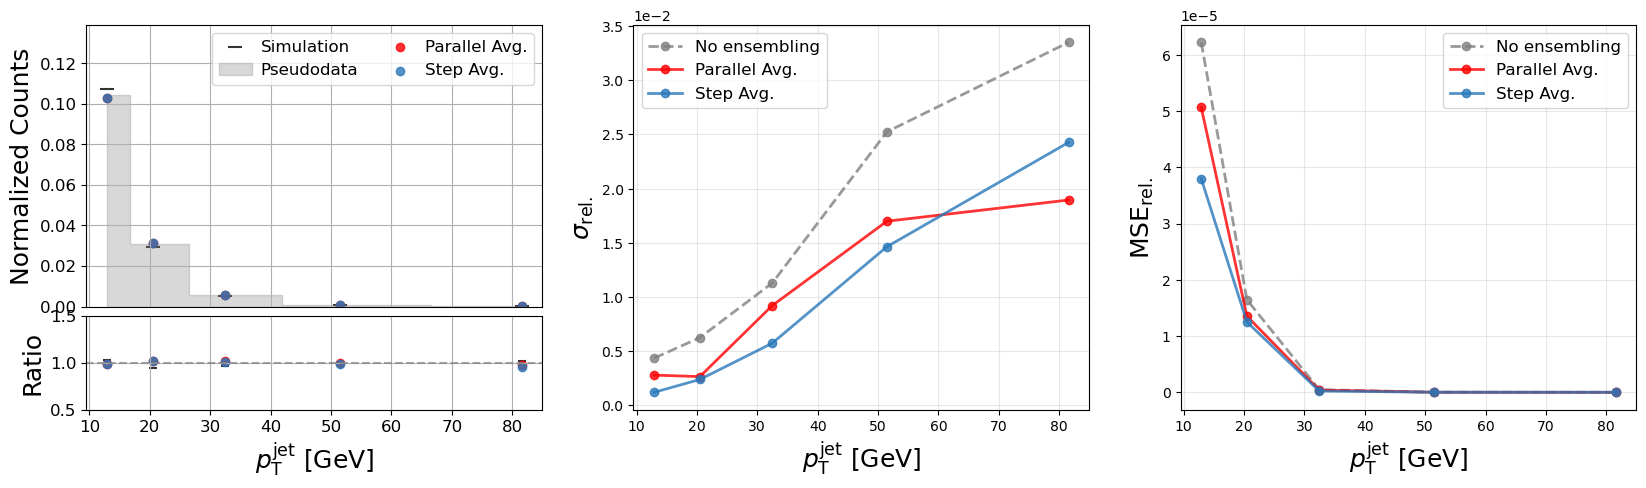

In [30]:
plot_feature('jet_pT', r'$p_\mathrm{T}^\mathrm{jet}$', r'$p_\mathrm{T}^\mathrm{jet}$', '[GeV]', drawmedian, drawstep)

/tmp/ipykernel_1594346/1062676158.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1594346/1062676158.py:220: RuntimeWarning: divide by zero encountered in divide
  mse = bias_squared/np.mean(chunk_means, axis=0)
/tmp/ipykernel_1594346/1907980734.py:11: RuntimeWarning: invalid value encountered in divide
  sigma = np.std(y_vals, axis=0)/np.mean(y_vals, axis=0)
/tmp/ipykernel_1594346/1062676158.py:308: RuntimeWarning: invalid value encountered in divide
  step_stdv = np.std(y_vals_step, axis=0)/np.mean(y_vals_step, axis=0)


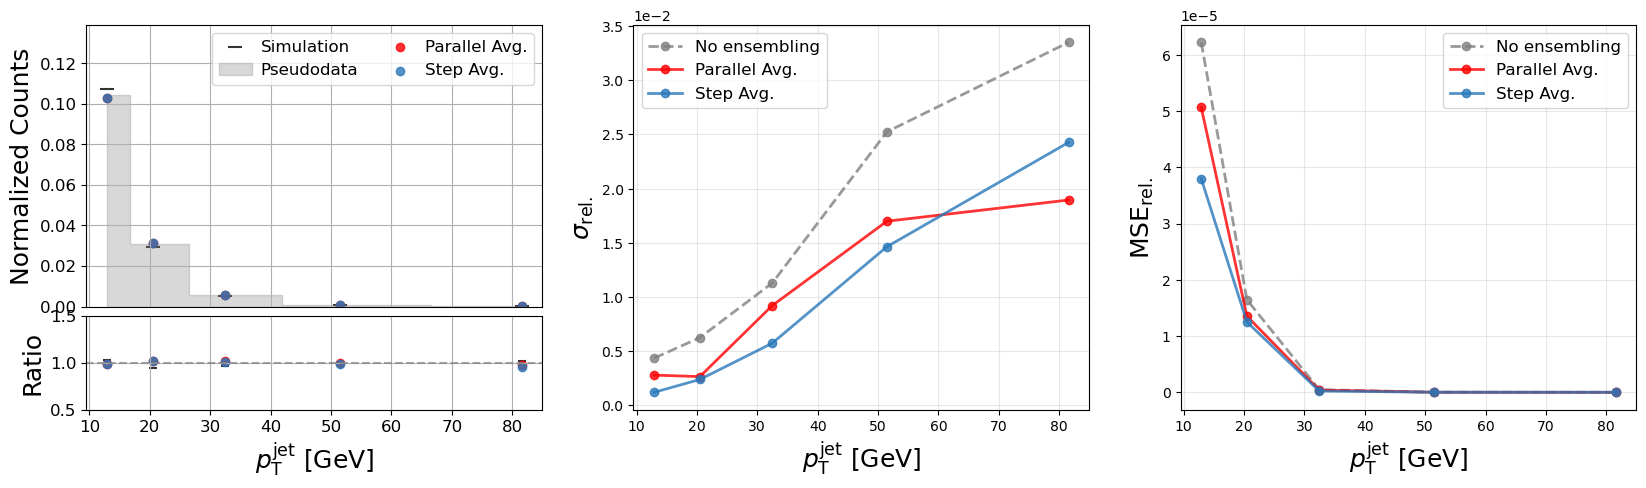

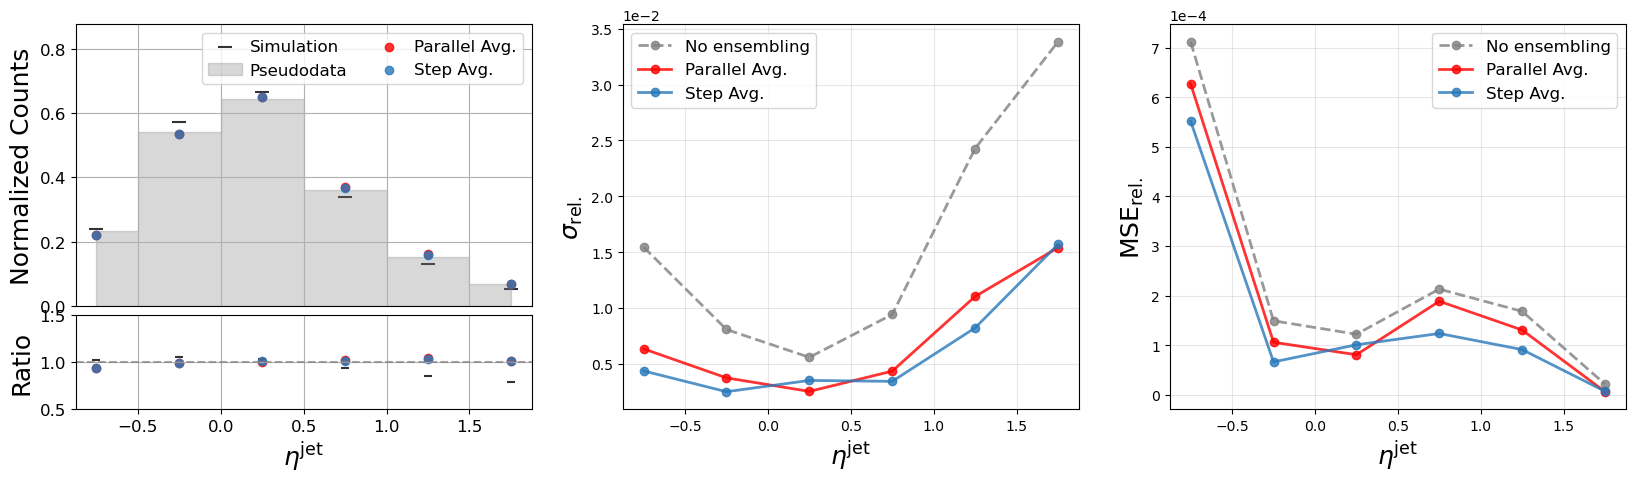

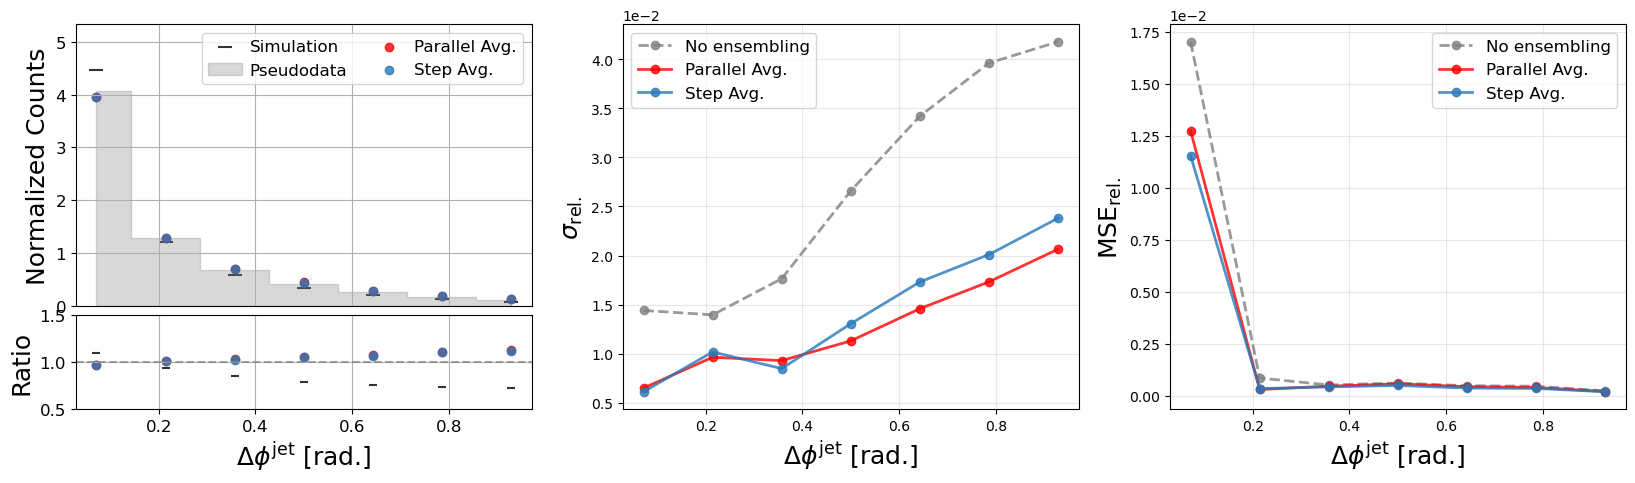

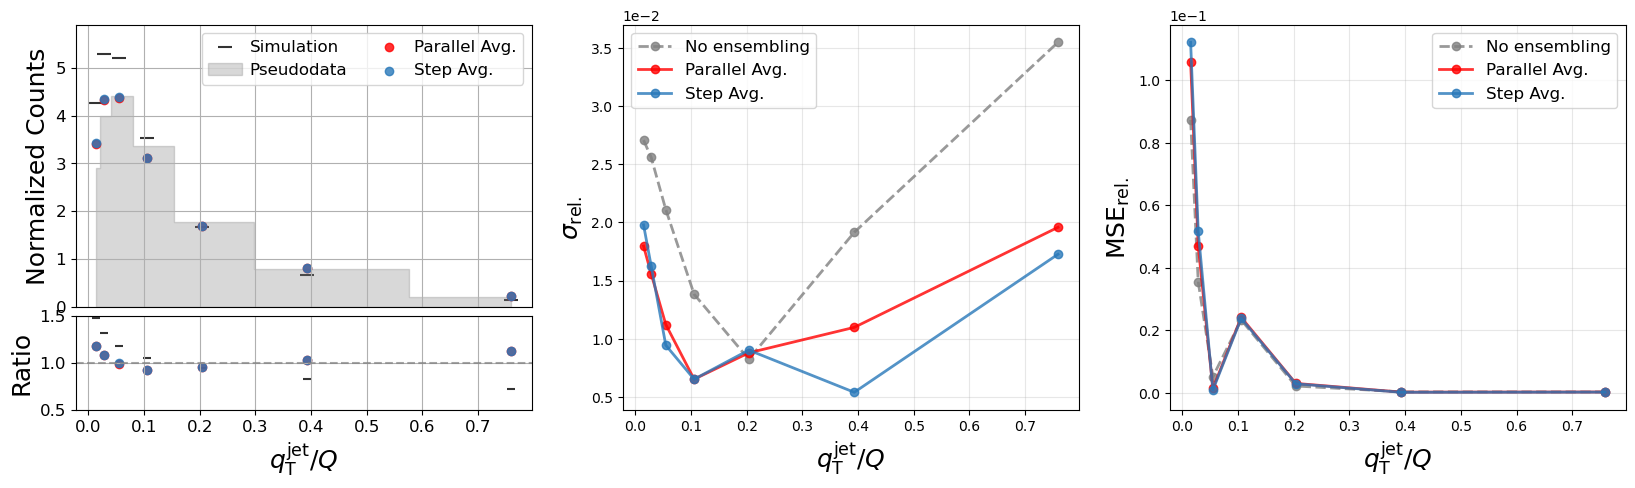

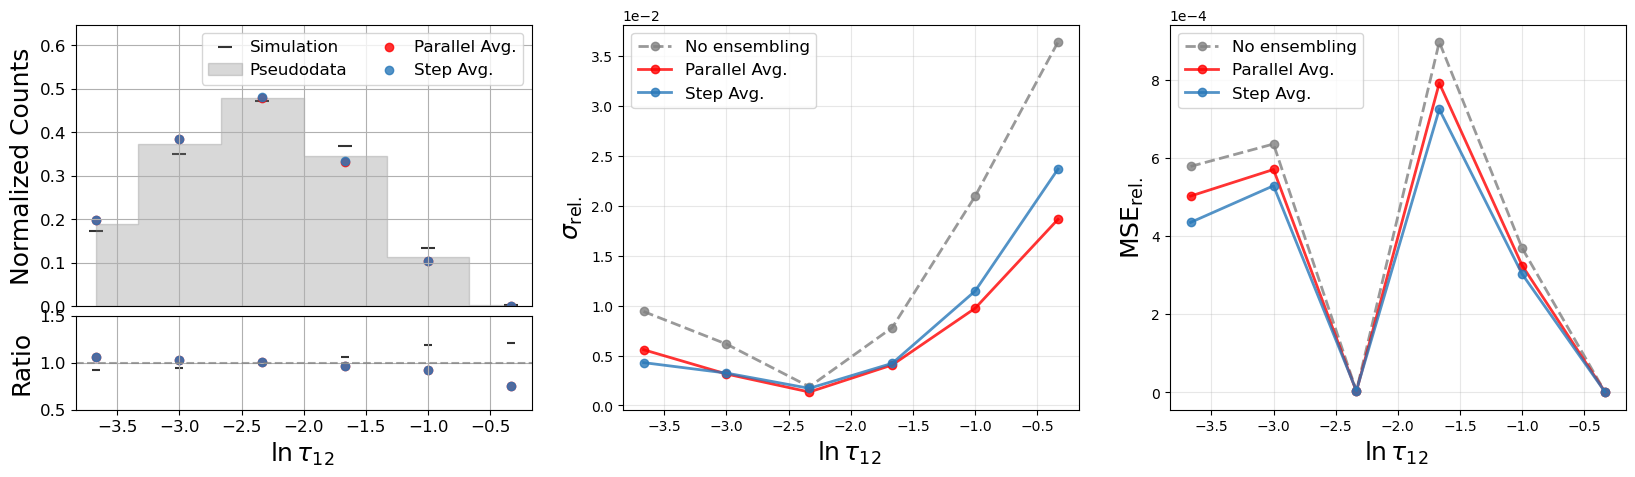

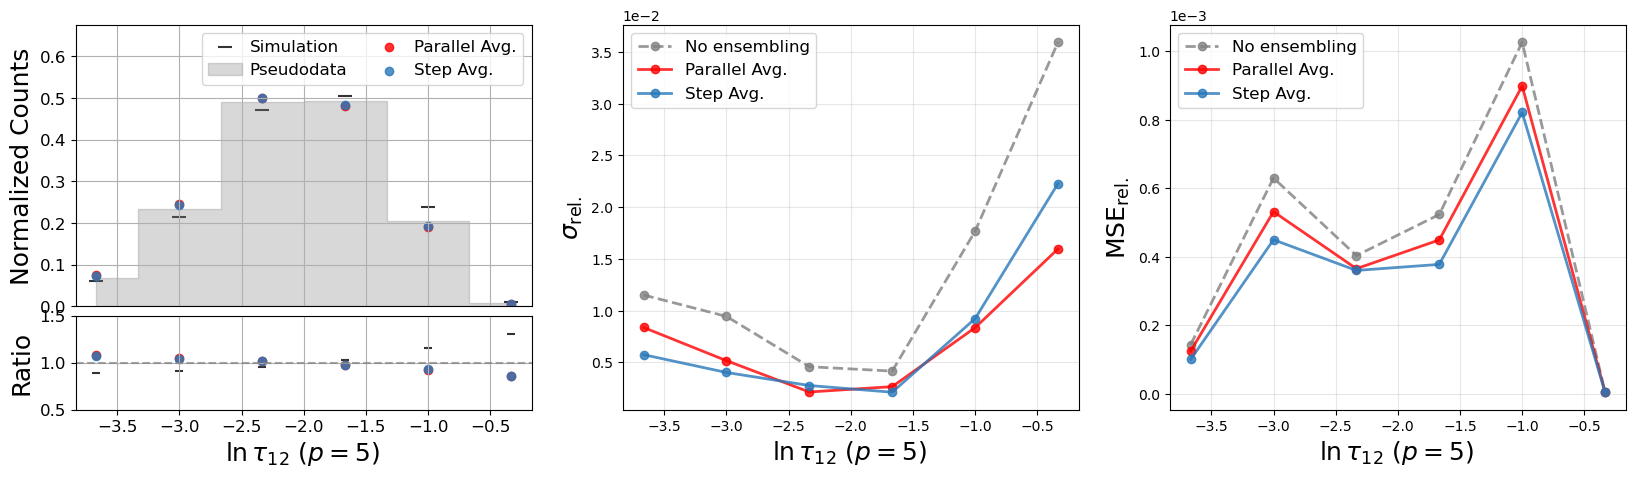

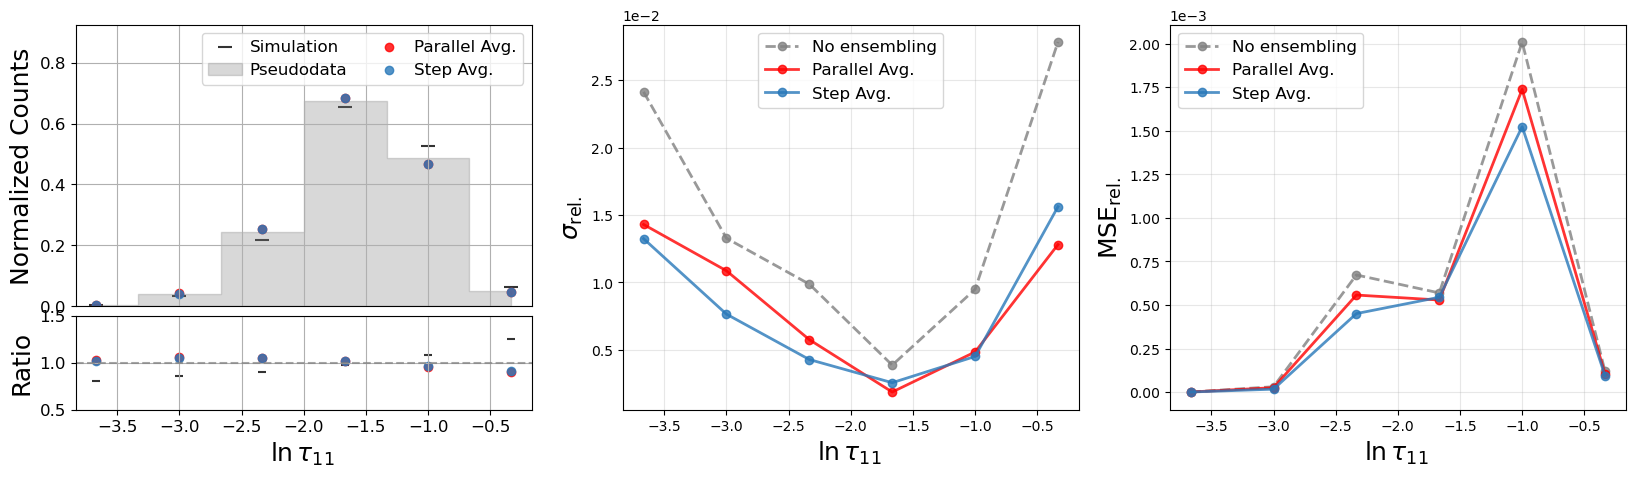

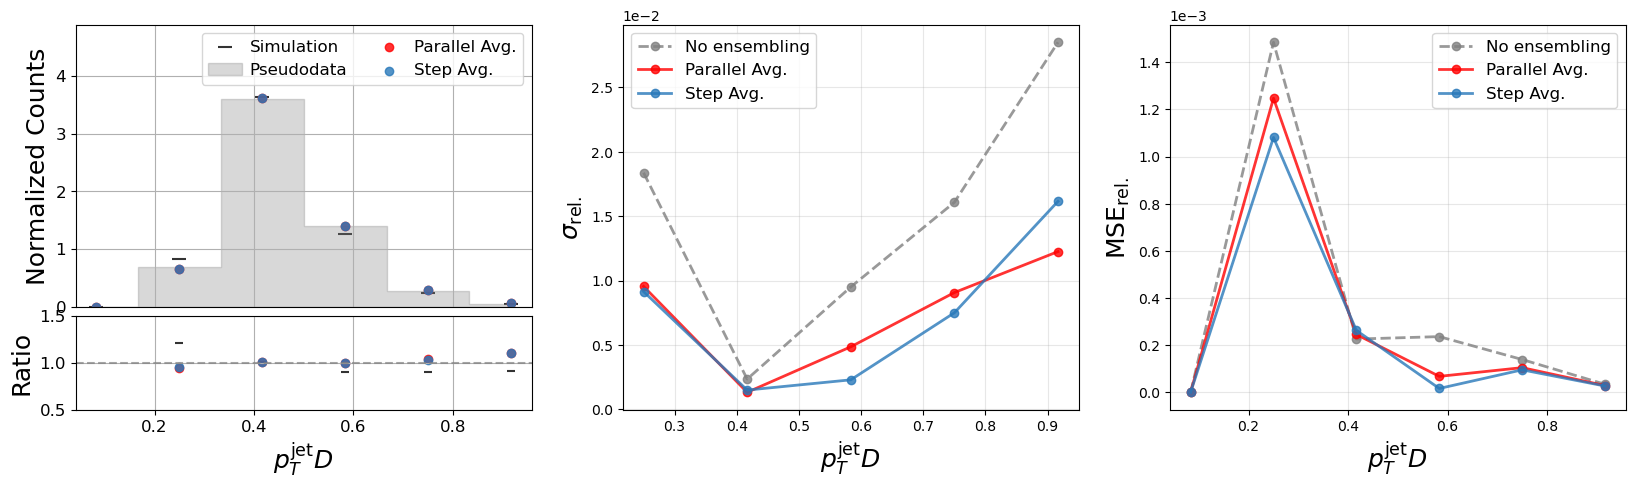

In [34]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT', 'jet_tau12', 'jet_tau11p5', 'jet_tau11', 'jet_ptD']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
              r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}/Q$', 
              r'$\ln \tau_{12}$', r'$\ln \tau_{12}\ (p=5)$', r'$\ln \tau_{11}$', '$p^\mathrm{jet}_{T}D$']
units = ['[GeV]','','[rad.]','','','','','']
for jet_feature, jet_label, unit in zip(jet_features, jet_labels, units):
    plot_feature(jet_feature, jet_label, jet_label, unit, drawmedian, drawstep )

/tmp/ipykernel_1594346/1062676158.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_1594346/1062676158.py:220: RuntimeWarning: invalid value encountered in divide
  mse = bias_squared/np.mean(chunk_means, axis=0)
/tmp/ipykernel_1594346/1062676158.py:232: RuntimeWarning: invalid value encountered in divide
  rapgap_ratio = plot_rapgap[1]/plot_djangoh[1] if avg_Npts > 0 else rapgap[1]/djangoh[1]
/tmp/ipykernel_1594346/1062676158.py:240: RuntimeWarning: invalid value encountered in divide
  x_values, final_mean/djangoh_vals,
/tmp/ipykernel_1594346/1907980734.py:11: RuntimeWarning: invalid value encountered in divide
  sigma = np.std(y_vals, axis=0)/np.mean(y_vals, axis=0)
/tmp/ipykernel_1594346/1062676158.py:308: RuntimeWarning: invalid value encountered in divide
  step_stdv = np.std(y_vals_step, axis=0)/np.mean(y_vals_step, axis=0)
/tmp/ipykernel_1594346/1062676158.py:313: RuntimeWarning: invalid value encountered in divide
  x_values, y_vals_avg/djangoh_vals,


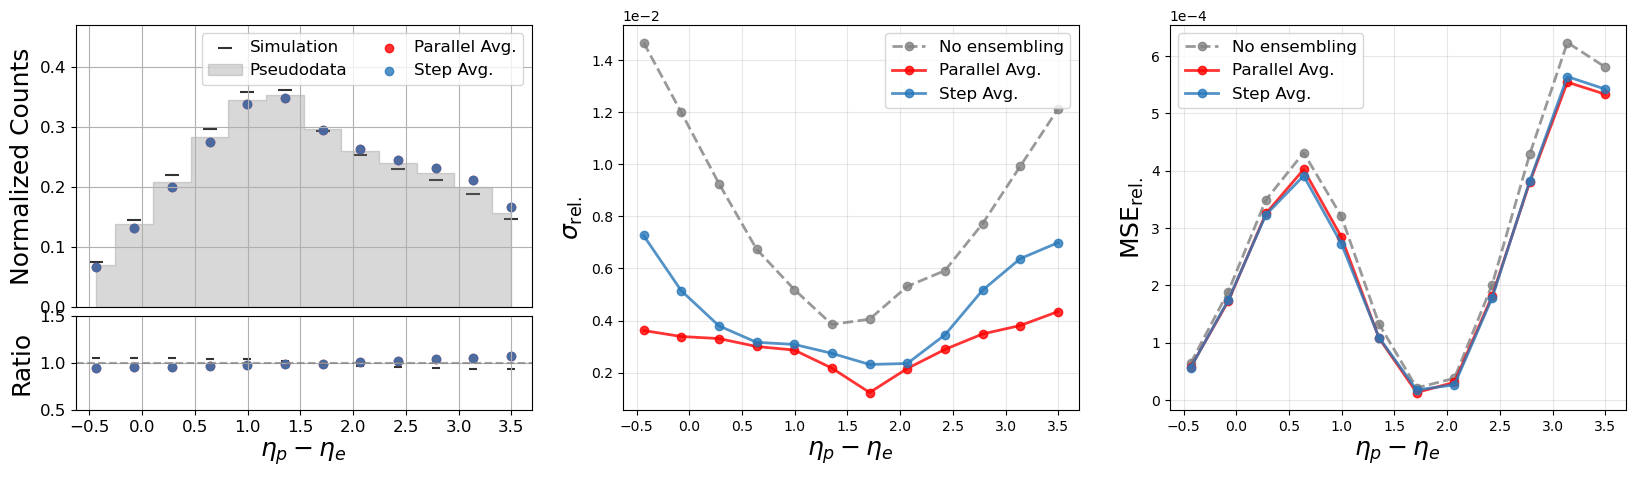

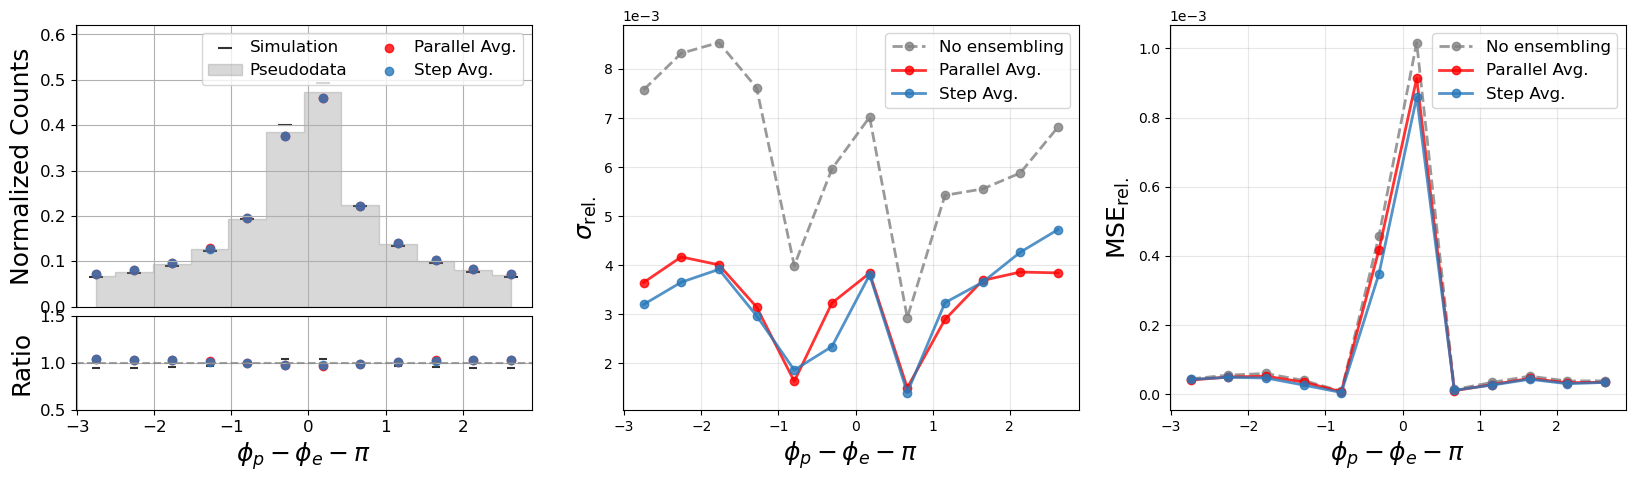

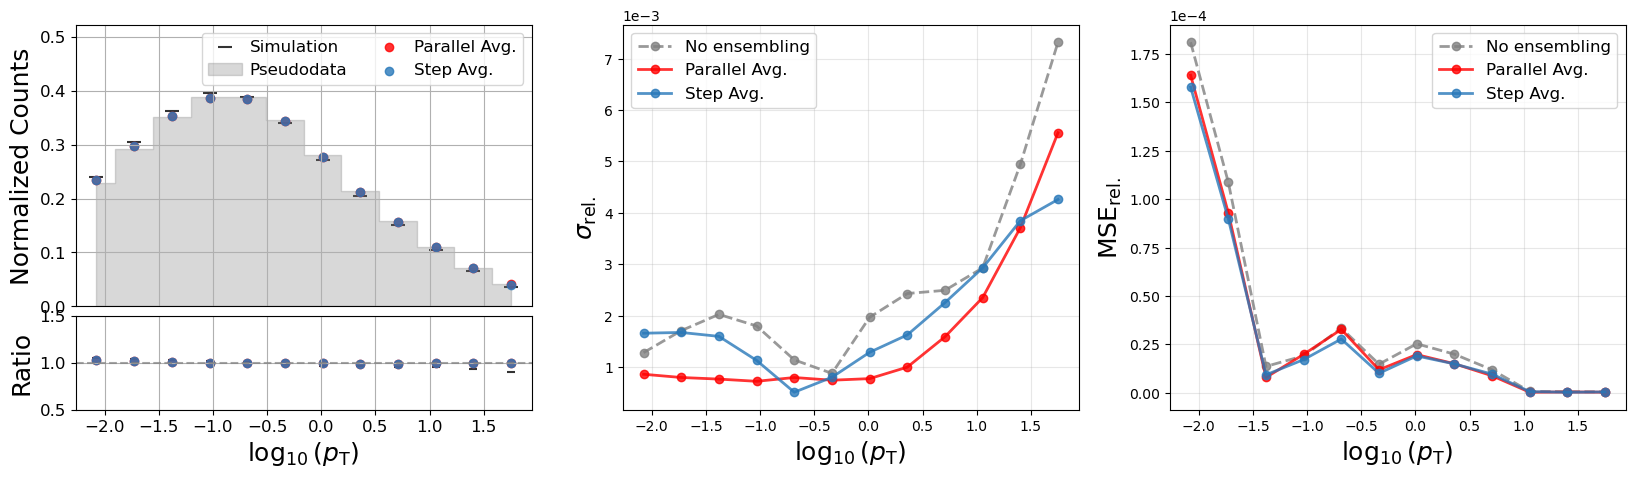

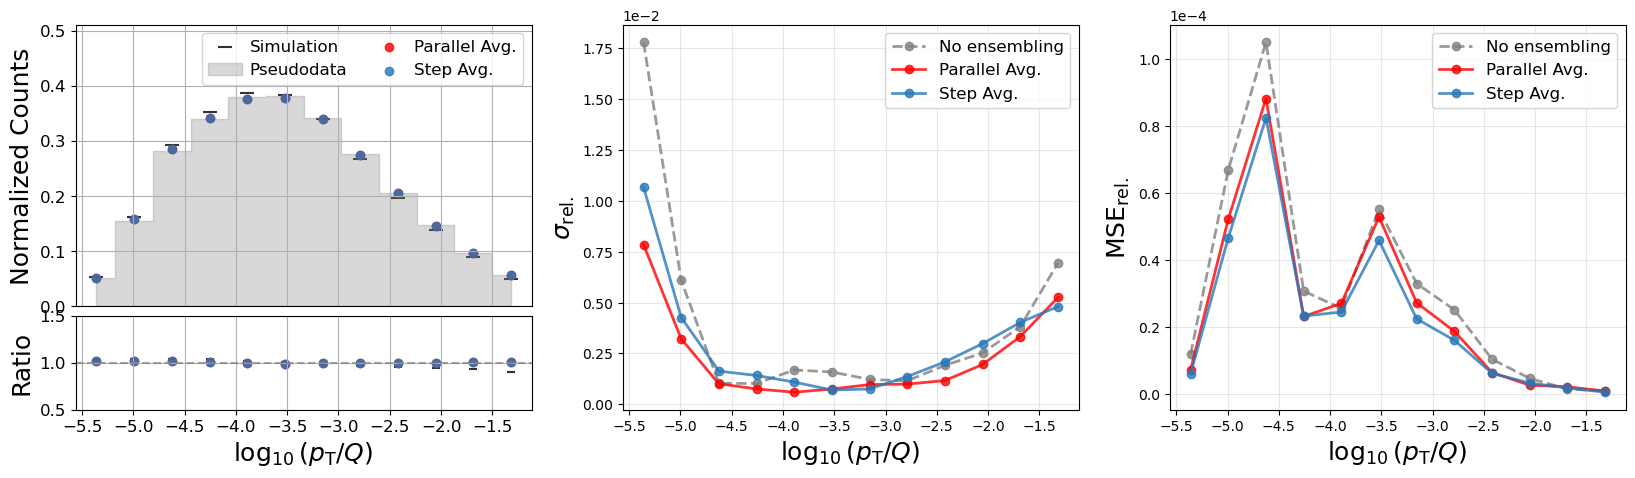

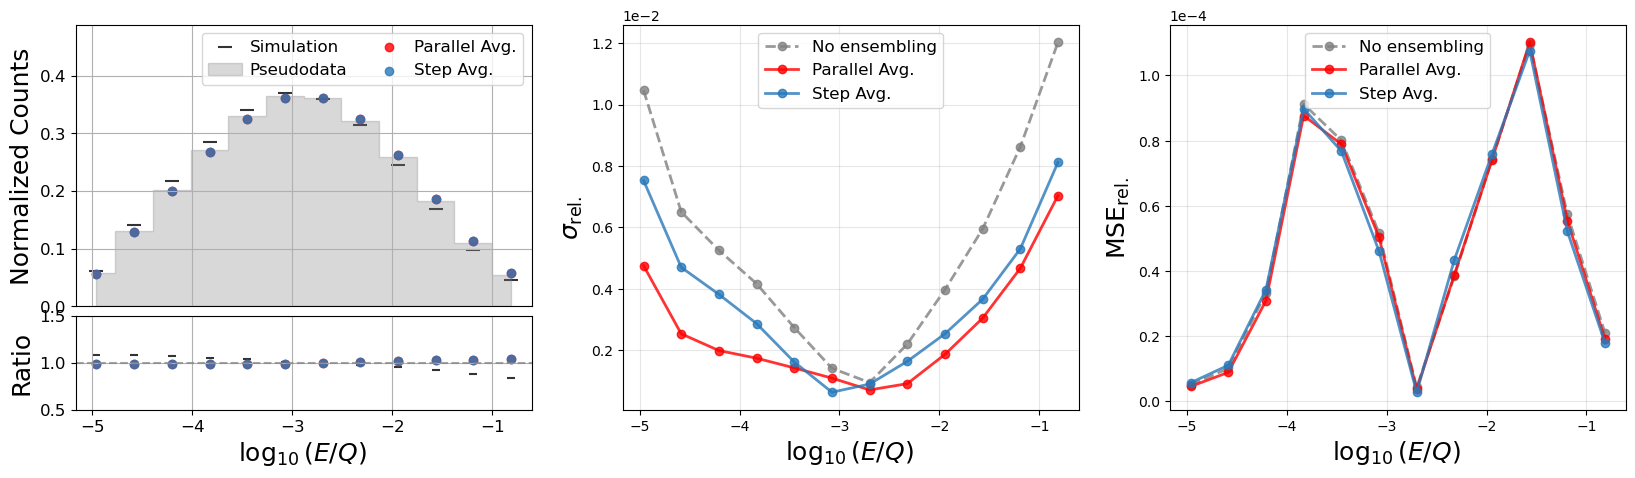

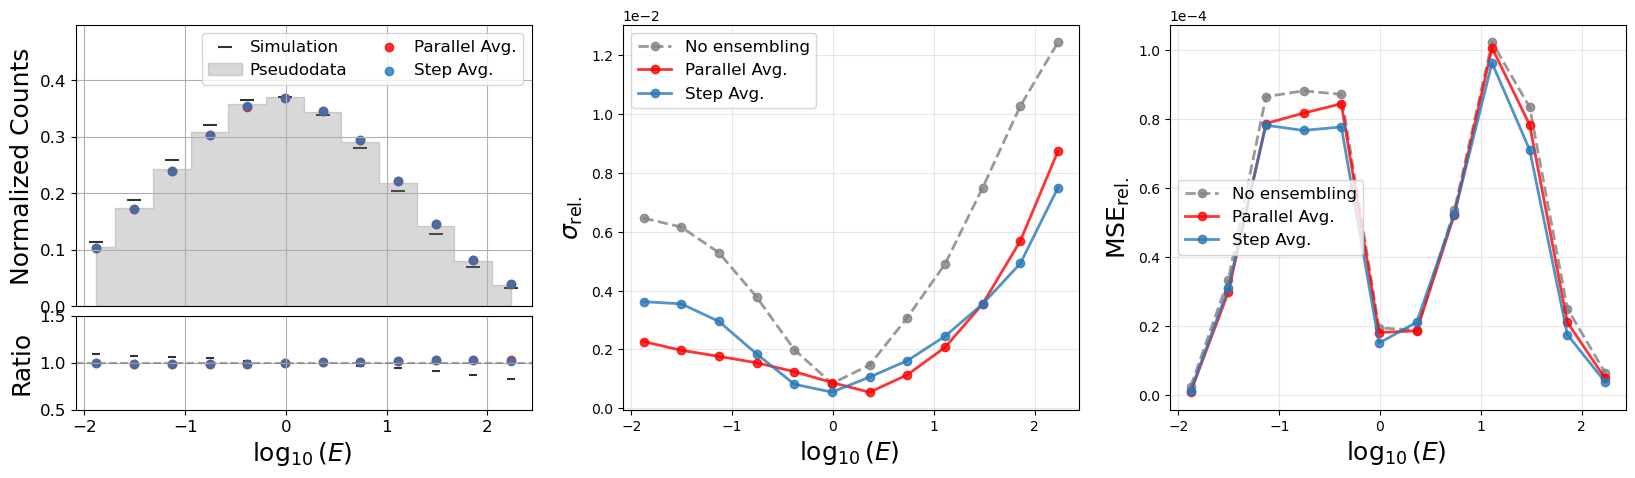

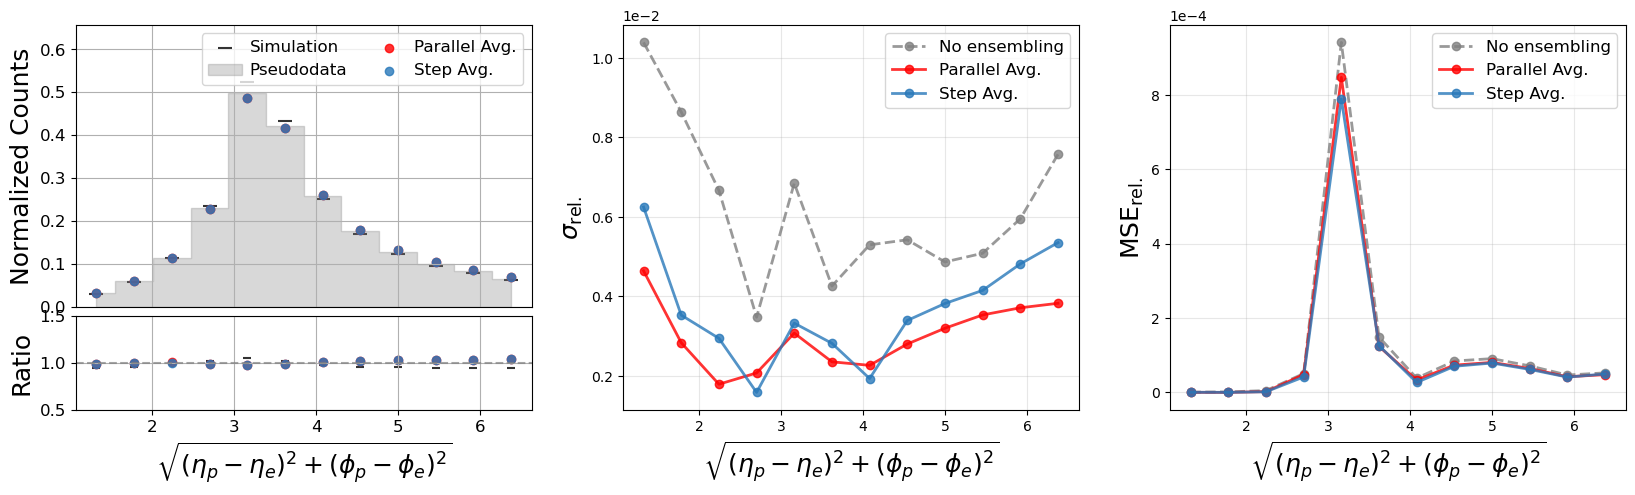

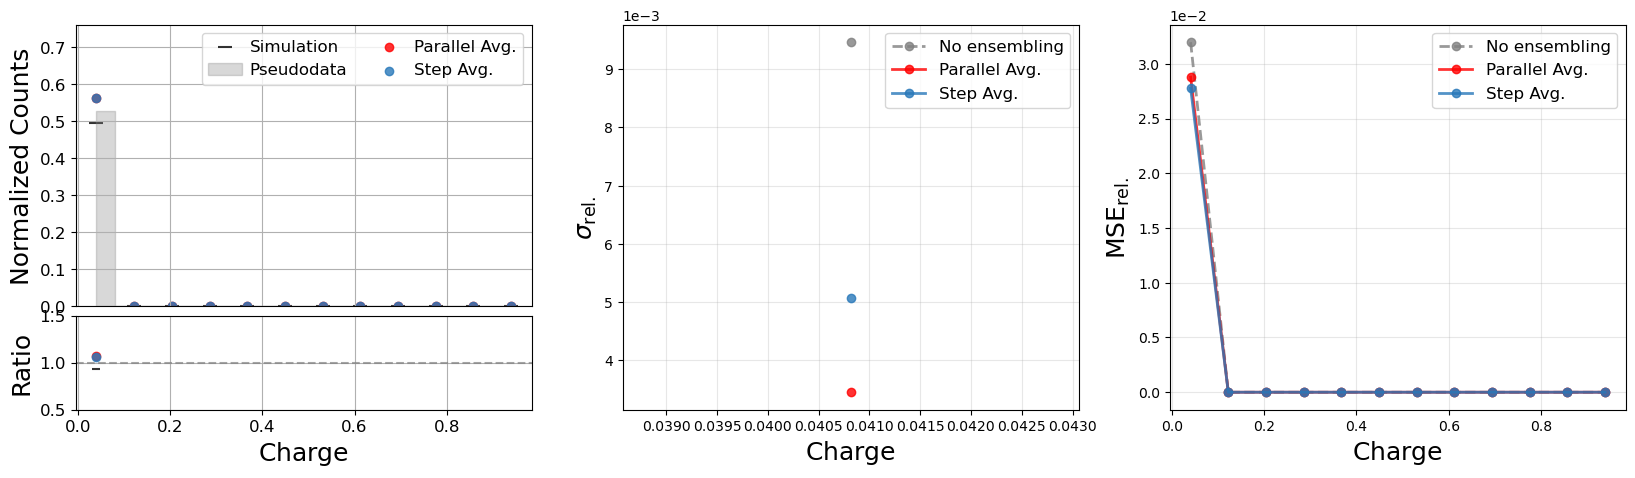

In [35]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']

particle_features = [f'particle{p}' for p in range(len(particle_labels))]
avg_Npts = 4
for particle_feature, particle_label in zip(particle_features, particle_labels):
    plot_feature( particle_feature, particle_label, particle_label, unit, drawmedian,drawstep, avg_Npts)
    print()


/tmp/ipykernel_1594346/1062676158.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


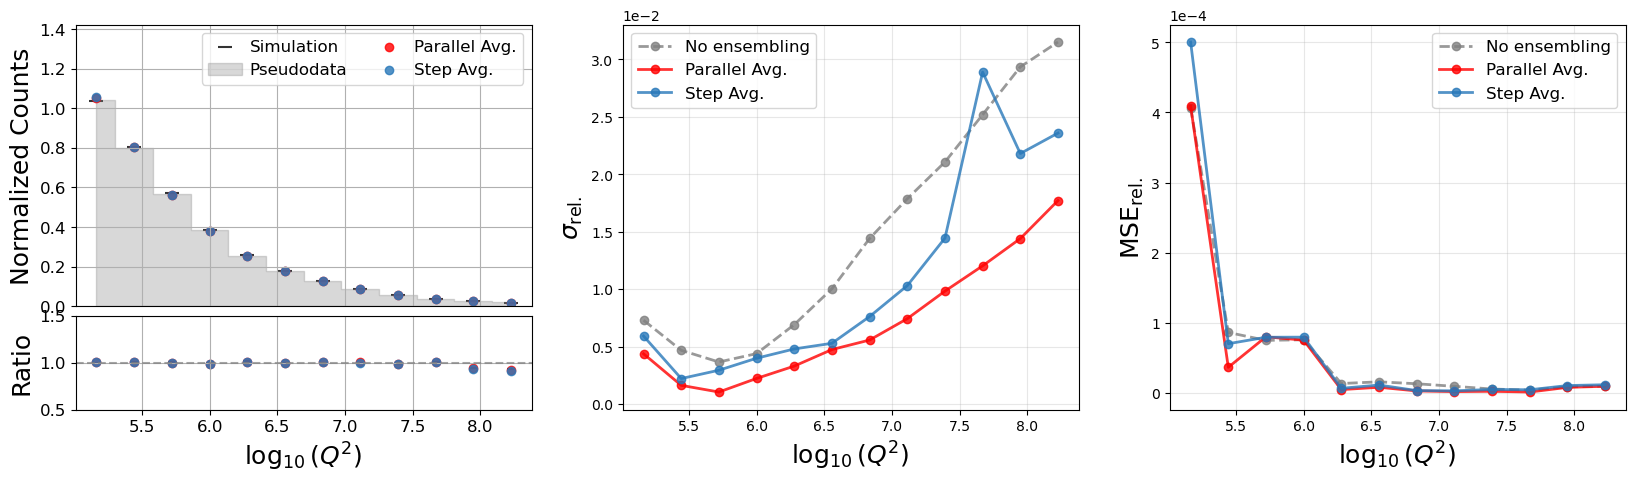

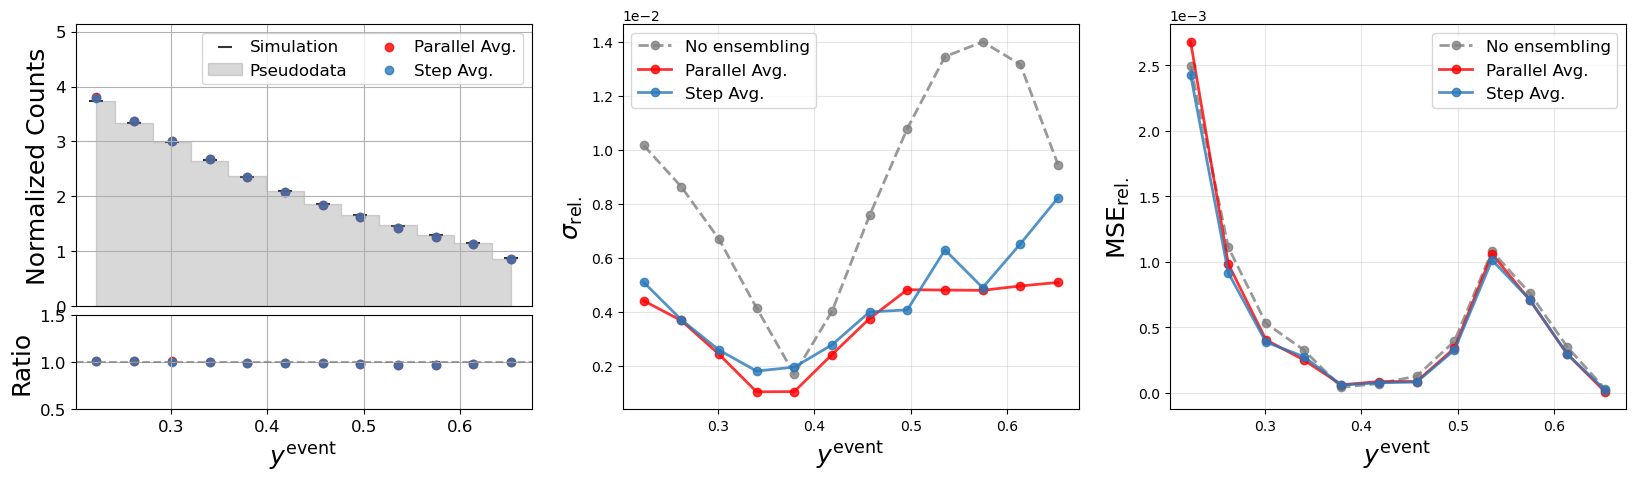

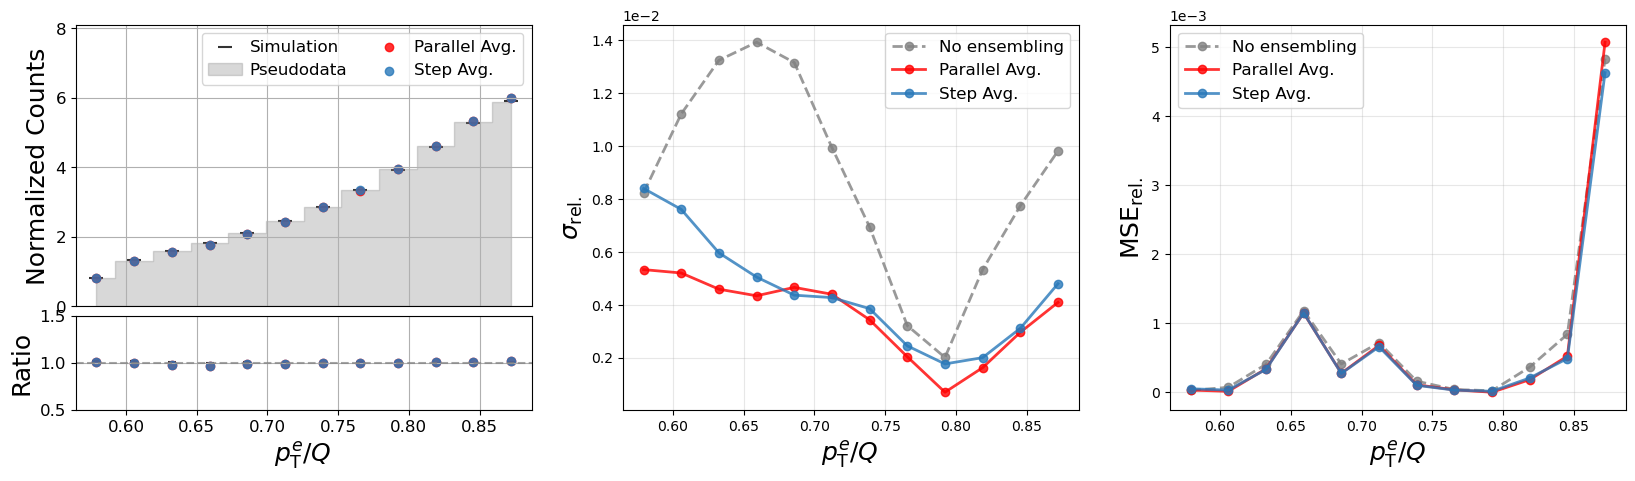

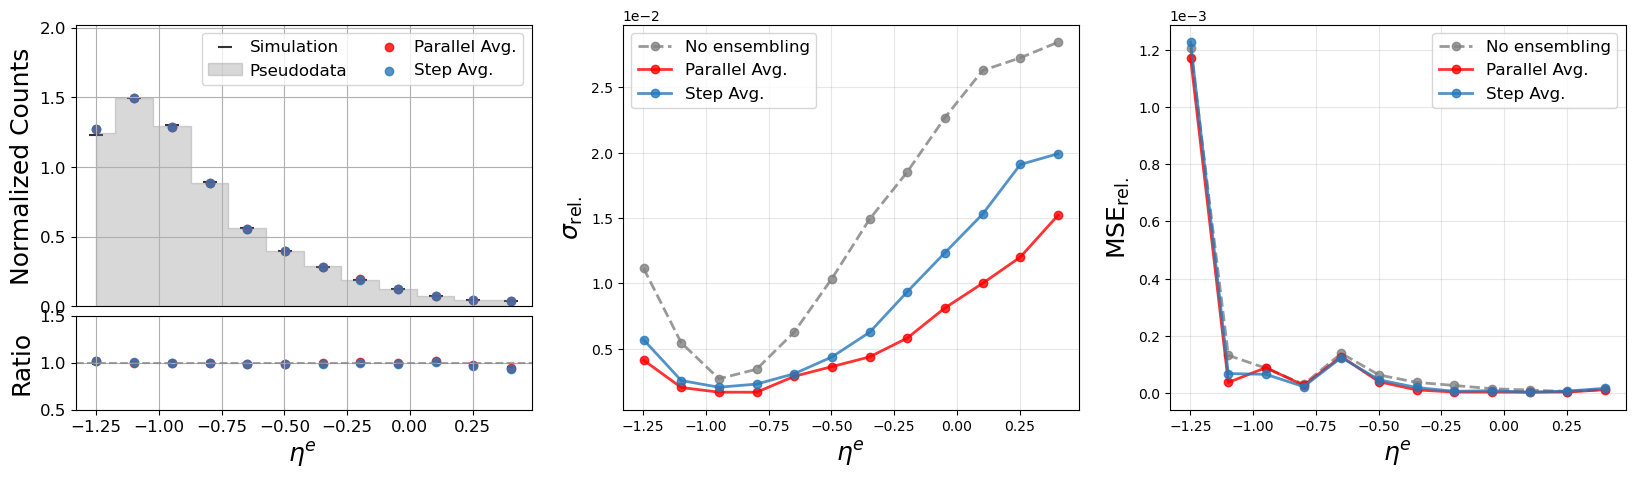

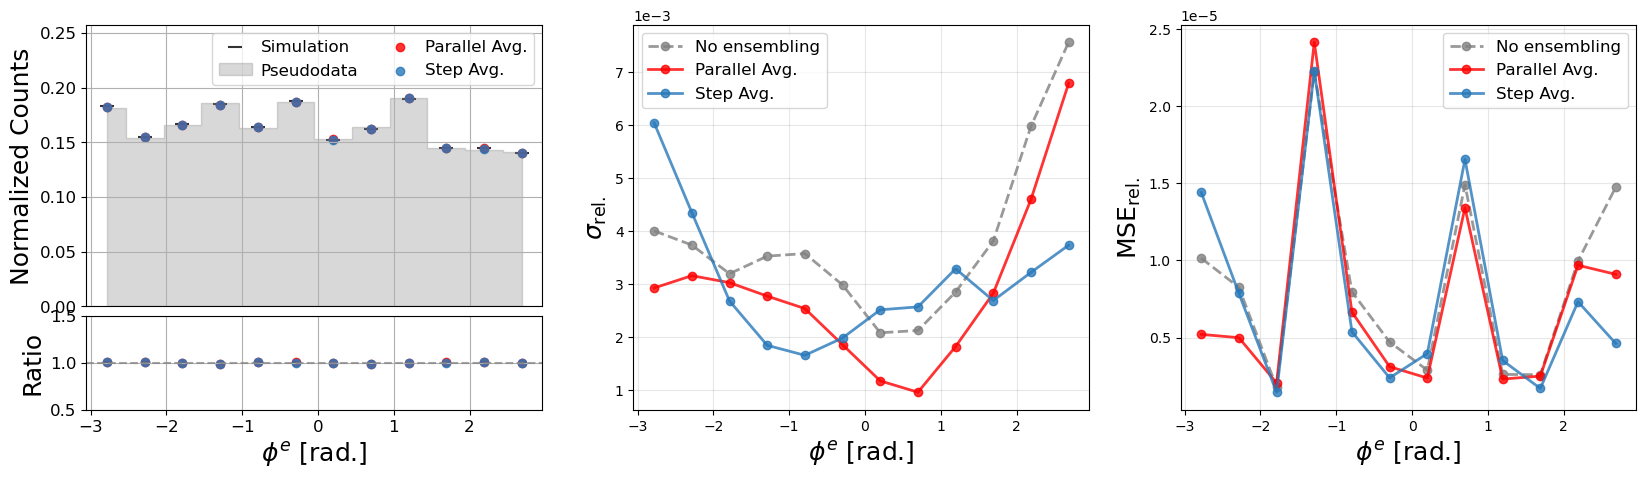

In [36]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y^\mathrm{event}$',r'$p_\mathrm{T}^e/Q$',r'$\eta^e$',r'$\phi^e$']
event_features = [f"event{e}" for e in range(len(event_labels))]
units = ["", "", "", "", "[rad.]"]
avg_Npts = 4
for event_feature, event_label, unit in zip(event_features, event_labels, units):
    plot_feature( event_feature, event_label, event_label, unit,drawmedian, drawstep, avg_Npts)
    print()